In [1]:
#hidden
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# the warnings in the libraries used can get old, do not show them
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install -Uqq fastai duckduckgo_search

In [4]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for {max_images} '{term}' images")
    return L(DDGS().images(term, max_results=max_images)).itemgot('image')    

In [5]:
from fastdownload import download_url
from fastai.vision.all import *

def download_validation_image(term):
    urls = search_images(f"{term} photos", max_images=1)

    dest = f"validation_data/{term}.jpg"
    download_url(urls[0], dest, show_progress=False)

    im = Image.open(dest)
    display(im.to_thumb(256,256))

Make it easier to swap out the model and see how things change by defining a variable to capture the model.

In [6]:
model=resnet34

Delete any prior training data, since we'll be adjusting size of the data set over time.

In [7]:
import shutil

# start with a clean (empty) set of data
shutil.rmtree('training_data', ignore_errors=True)
shutil.rmtree('validation_data', ignore_errors=True)

Initialize a dictionary to capture the data.

We'll be doing a few iterations and this supports a simple tabular summary at the end.  And simplifies validation.

In [8]:
results = {
    "sandwich": {},
    "poptart": {},
    "hot dog": {},
    "pug": {},
    "car": {},
    "salad": {},
    "tree": {},
    "pizza": {},
}

Load a validation image for each of our samples.

Searching for 1 'sandwich photos' images


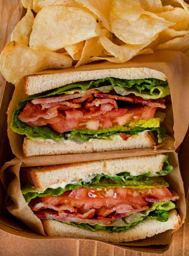

Searching for 1 'poptart photos' images


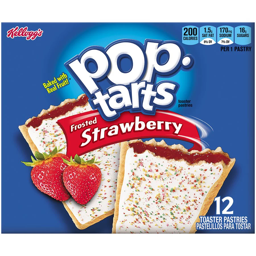

Searching for 1 'hot dog photos' images


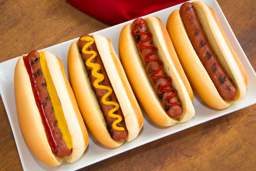

Searching for 1 'pug photos' images


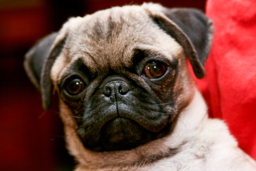

Searching for 1 'car photos' images


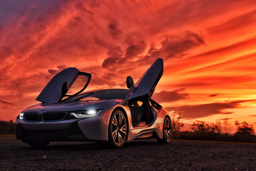

Searching for 1 'salad photos' images


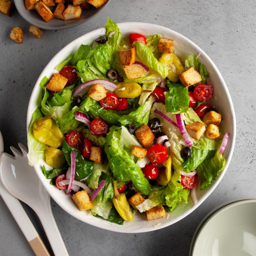

Searching for 1 'tree photos' images


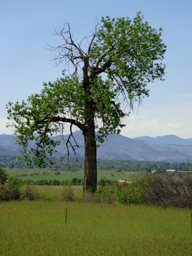

Searching for 1 'pizza photos' images


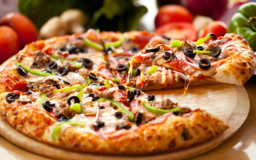

In [9]:
for term in results.keys():
    download_validation_image(term)

Load initial training data.

In [10]:
import glob
import os

searches = {
    'sandwich': ['sandwich'],
    'not sandwich': ['landscape', 'building', 'animal', 'insect', 'person'],
}
path = Path('training_data')
from time import sleep

max_images=1000

for key in searches:
    dest = (path/key)
    dest.mkdir(exist_ok=True, parents=True)
    images_per_key=int(max_images/len(searches[key]))
    for o in searches[key]:
        download_images(dest, urls=search_images(f'"{o}" photo', images_per_key))
        sleep(10)  # Pause between searches to avoid over-loading server (this was in examples.. is it necessary?)
    # cleanup images before moving forward
    for filename in glob.glob(f"{dest}/*.avi*"):
        os.remove(filename)
    failed = verify_images(get_image_files(dest))
    failed.map(Path.unlink)
    resize_images(dest, max_size=400, dest=dest)

Searching for 1000 '"sandwich" photo' images
Searching for 200 '"landscape" photo' images
Searching for 200 '"building" photo' images
Searching for 200 '"animal" photo' images


KeyboardInterrupt: 

Build a data block for training with 20% of the data used for validation.

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, model, metrics=accuracy)
learn.fine_tune(3)

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
def check_category(test_name="default"):
    for term in results.keys():
        # get the prediction
        dest=f"validation_data/{term}.jpg"
        category,category_num,probs = learn.predict(PILImage.create(dest))
        # show prediction
        print(f"This is a: {category}")
        print(f"Probability it's a {category}: {probs[category_num]:.4f}")
        # show image
        im = Image.open(dest)
        display(im.to_thumb(256,256))
        # save data for later
        if test_name not in results[term]:
            results[term][test_name] = {
                "category": "",
                "probability": "",
            }
        results[term][test_name]['category'] = category
        results[term][test_name]['probability'] = f"{probs[category_num]:.4f}"

In [ ]:
check_category()

In [ ]:
import pandas as pd
col=[] # use list so we keep order
data = {}
for term in results.keys():
    if term not in data:
        data[term] = []
    for test in results[term]:
        if test not in col:
            col.append(test)
        data[term].append(f"{results[term][test]['category']} ({float(results[term][test]['probability'])*100:.0f}%)")
pd.DataFrame(data.values(), index=data.keys(), columns=list(col))

export the model so we can run an app

In [ ]:
learn.export(fname="sandwich.pkl")